In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

import re
import nltk
nltk.download('all')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()

warnings.filterwarnings("ignore")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/RNN/Clothing-Review.csv")
print(data.head(7))
print(data.shape)

data = data[data['Class Name'].isnull() == False] # Xóa các dòng có tên sản phẩm để trống

   Clothing ID  Age                    Title  \
0          767   33                      NaN   
1         1080   34                      NaN   
2         1077   60  Some major design flaws   
3         1049   50         My favorite buy!   
4          847   47         Flattering shirt   
5         1080   49  Not for the very petite   
6          858   39     Cagrcoal shimmer fun   

                                         Review Text  Rating  Recommended IND  \
0  Absolutely wonderful - silky and sexy and comf...       4                1   
1  Love this dress!  it's sooo pretty.  i happene...       5                1   
2  I had such high hopes for this dress and reall...       3                0   
3  I love, love, love this jumpsuit. it's fun, fl...       5                1   
4  This shirt is very flattering to all due to th...       5                1   
5  I love tracy reese dresses, but this one is no...       2                0   
6  I aded this in my basket at hte last mintue t

In [ ]:
print(data[['Age', 'Rating', 'Positive Feedback Count']].describe()) # Thống kê mô tả

                Age        Rating  Positive Feedback Count
count  23472.000000  23472.000000             23472.000000
mean      43.200707      4.195552                 2.537151
std       12.280913      1.110188                 5.703597
min       18.000000      1.000000                 0.000000
25%       34.000000      4.000000                 0.000000
50%       41.000000      5.000000                 1.000000
75%       52.000000      5.000000                 3.000000
max       99.000000      5.000000               122.000000


In [ ]:
print(data['Class Name'].value_counts())
print(data['Recommended IND'].value_counts(normalize=True)) # Thống kê lương người khuyên dùng sản phẩm

Class Name
Dresses           6319
Knits             4843
Blouses           3097
Sweaters          1428
Pants             1388
Jeans             1147
Fine gauge        1100
Skirts             945
Jackets            704
Lounge             691
Swim               350
Outerwear          328
Shorts             317
Sleep              228
Legwear            165
Intimates          154
Layering           146
Trend              119
Casual bottoms       2
Chemises             1
Name: count, dtype: int64
Recommended IND
1    0.822256
0    0.177744
Name: proportion, dtype: float64


EDA

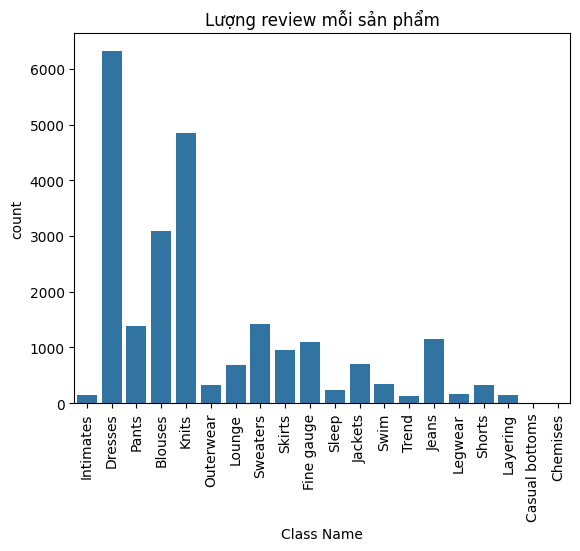

In [ ]:
# Biểu đồ cột thể hiện lượng review mỗi sản phẩm
sns.countplot(data=data, x='Class Name')
plt.title('Lượng review mỗi sản phẩm')
plt.xticks(rotation=90)
plt.show()

1. Cấu trúc biểu đồ: Đây là một biểu đồ cột, với trục hoành biểu thị các loại sản phẩm (Class Name) và trục tung biểu thị số lượng review tương ứng cho mỗi loại sản phẩm. Các nhãn trên trục hoành được xoay 90 độ để dễ đọc hơn do có nhiều loại sản phẩm.
2. Phân tích số liệu:
- Các loại sản phẩm có nhiều review nhất: Rõ ràng nhất, các cột cao nhất thuộc về các loại sản phẩm như Dresses (Đầm/Váy), Knits (Đồ dệt kim), và Blouses (Áo kiểu). Điều này cho thấy đây là những loại sản phẩm phổ biến nhất hoặc nhận được nhiều sự chú ý, quan tâm từ khách hàng nhất, dẫn đến số lượng review lớn.
- Các loại sản phẩm có lượng review trung bình: Tiếp theo là các loại sản phẩm như Sweaters (Áo len), Pants (Quần), Jeans (Quần jeans), Fine gauge (Đồ dệt kim mỏng), và Skirts (Chân váy). Lượng review cho các loại này ít hơn so với nhóm đầu tiên nhưng vẫn đáng kể.
- Các loại sản phẩm có ít review nhất: Các loại sản phẩm còn lại như Jackets (Áo khoác), Lounge (Đồ mặc ở nhà), Swim (Đồ bơi), Outerwear (Đồ mặc ngoài), Shorts (Quần short), Sleep (Đồ ngủ), Legwear (Đồ mặc chân), Intimates (Đồ lót), Layering (Đồ mặc lớp trong), và Trend (Đồ theo xu hướng) có số lượng review thấp hơn nhiều. Đặc biệt, các loại như Casual bottoms và Chemises có số lượng review cực kỳ ít.
3. Ý nghĩa:
- Sự phổ biến của sản phẩm: Số lượng review có thể là một chỉ báo về mức độ phổ biến hoặc doanh số của từng loại sản phẩm. Các loại có nhiều review có thể là những mặt hàng bán chạy hoặc được nhiều người mua và sử dụng.
- Tập trung phân tích: Biểu đồ này giúp xác định những loại sản phẩm mà chúng ta có nhiều dữ liệu review nhất. Khi thực hiện các phân tích sâu hơn (ví dụ: phân tích cảm xúc từ nội dung review), việc tập trung vào các loại sản phẩm có nhiều review sẽ mang lại kết quả đáng tin cậy hơn.
- Cơ hội và thách thức: Đối với các loại sản phẩm có ít review, có thể khó rút ra kết luận chắc chắn về sự hài lòng của khách hàng dựa trên dữ liệu review. Doanh nghiệp có thể cần tìm cách khuyến khích khách hàng viết review cho những sản phẩm này hoặc sử dụng các nguồn dữ liệu khác để đánh giá hiệu quả của chúng.
- Chiến lược kinh doanh: Thông tin này có thể hữu ích cho việc hoạch định chiến lược kinh doanh, ví dụ: tập trung marketing vào các sản phẩm phổ biến, hoặc tìm hiểu lý do tại sao một số sản phẩm khác lại ít được review.

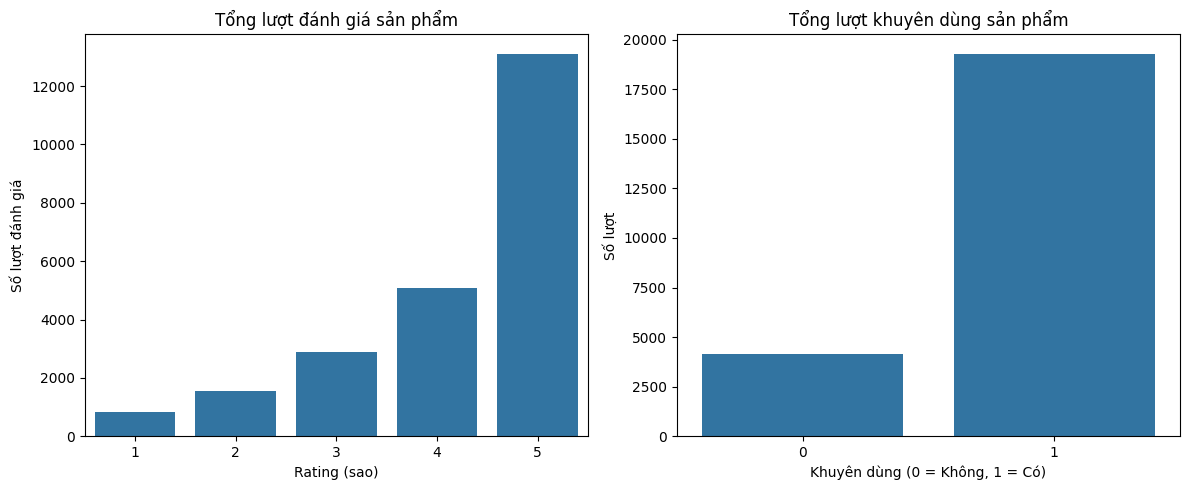

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Biểu đồ cột thể hiện tổng lượt đánh giá sản phẩm
sns.countplot(data=data, x='Rating', ax=axes[0])
axes[0].set_title('Tổng lượt đánh giá sản phẩm')
axes[0].set_xlabel('Rating (sao)')
axes[0].set_ylabel('Số lượt đánh giá')

# Biểu đồ cột thể hiện tổng lượt khuyên dùng sản phẩm
sns.countplot(data=data, x="Recommended IND", ax=axes[1])
axes[1].set_title('Tổng lượt khuyên dùng sản phẩm')
axes[1].set_xlabel('Khuyên dùng (0 = Không, 1 = Có)')
axes[1].set_ylabel('Số lượt')

# Hiển thị
plt.tight_layout()
plt.show()


###Biểu đồ 1: Tổng lượt đánh giá sản phẩm (Rating)

1. Cấu trúc biểu đồ: Đây là một biểu đồ cột đơn giản thể hiện số lượng (tần suất) của từng mức đánh giá từ 1 đến 5 sao trong toàn bộ tập dữ liệu. Trục hoành biểu thị các mức đánh giá (1, 2, 3, 4, 5), và trục tung biểu thị số lượng đánh giá tương ứng.
2. Phân tích số liệu:
- Đánh giá tích cực chiếm ưu thế: Rõ ràng nhất, các cột tương ứng với đánh giá 4 sao và 5 sao cao hơn đáng kể so với các cột còn lại. Đặc biệt, đánh giá 5 sao có số lượng vượt trội. Điều này cho thấy phần lớn khách hàng rất hài lòng với sản phẩm và đưa ra đánh giá tích cực.
- Đánh giá trung bình và tiêu cực ít hơn: Số lượng đánh giá 3 sao (trung bình) thấp hơn nhiều so với 4 và 5 sao. Đánh giá 1 sao và 2 sao (tiêu cực) có số lượng rất thấp, là các cột thấp nhất trên biểu đồ.
3. Ý nghĩa: Biểu đồ này cung cấp cái nhìn tổng quan về mức độ hài lòng của khách hàng đối với sản phẩm. Tỷ lệ đánh giá tích cực cao cho thấy chất lượng sản phẩm hoặc trải nghiệm mua sắm nhìn chung là tốt đối với phần lớn khách hàng.

###Biểu đồ 2: Tổng lượt khuyên dùng sản phẩm (Recommended IND)

1. Cấu trúc biểu đồ: Biểu đồ này cũng là một biểu đồ cột, hiển thị số lượng khách hàng đã khuyên dùng sản phẩm (Recommended IND = 1) và số lượng khách hàng không khuyên dùng sản phẩm (Recommended IND = 0). Trục hoành biểu thị hai lựa chọn (0 và 1), và trục tung hiển thị số lượng tương ứng.
2. Phân tích số liệu:
Tỷ lệ khuyên dùng cao: Cột tương ứng với Recommended IND = 1 (khuyên dùng) cao hơn rất nhiều so với cột Recommended IND = 0 (không khuyên dùng). Điều này trực quan xác nhận lại tỷ lệ khuyên dùng tổng thể đã được tính toán trước đó (khoảng 82%).
3. Ý nghĩa: Biểu đồ này cho thấy mức độ sẵn lòng giới thiệu sản phẩm của khách hàng. Tỷ lệ khuyên dùng cao là một chỉ báo mạnh mẽ về sự hài lòng và lòng trung thành của khách hàng. Khách hàng không chỉ hài lòng với việc sử dụng sản phẩm mà còn sẵn sàng chia sẻ trải nghiệm tích cực và giới thiệu sản phẩm cho người khác, điều này rất quan trọng cho sự phát triển của doanh nghiệp thông qua marketing truyền miệng.

In [ ]:
# Biểu đồ thống kê lượng khuyên dùng/ không khuyên dùng theo độ tuổi
fig = px.histogram(data, marginal='box',
				x="Age", title="Thống kê lượt khuyên dùng theo độ tuổi",
				color="Recommended IND",
				nbins=65-18,
				color_discrete_sequence=['green', 'red'])
fig.update_layout(bargap=0.2)

1. Cấu trúc biểu đồ: Tương tự như biểu đồ đánh giá theo độ tuổi, đây là một histogram với marginal='box', hiển thị tần suất của từng độ tuổi trong dữ liệu. Điểm khác biệt chính là thuộc tính color="Recommended IND", phân chia các cột theo việc khách hàng có khuyên dùng sản phẩm hay không (1: Khuyên dùng, 0: Không khuyên dùng). nbins=65-18 giữ nguyên, đảm bảo mỗi độ tuổi trong khoảng đó có cột riêng. Màu sắc (color_discrete_sequence=['green', 'red']) giúp phân biệt rõ ràng giữa nhóm khuyên dùng (xanh lá cây) và không khuyên dùng (đỏ).
2. Phân phối tuổi của người đánh giá: Phân phối tuổi của những người tham gia đánh giá và khuyên dùng/không khuyên dùng sản phẩm là tương tự như phân phối tuổi trong biểu đồ đánh giá. Điều này là hợp lý vì cả hai biểu đồ đều sử dụng cùng một tập dữ liệu. Sự tập trung vẫn nằm ở nhóm tuổi trung niên (khoảng 30-60 tuổi), với số lượng đánh giá giảm dần ở hai đầu phổ tuổi. Box plot phía trên xác nhận lại phân phối tuổi này.
3. Phân tích lượt khuyên dùng theo từng độ tuổi:
- Nhóm tuổi trung niên (30-60): Đây là nhóm đóng góp số lượng đánh giá và quyết định khuyên dùng/không khuyên dùng lớn nhất. Quan sát các cột histogram trong khoảng tuổi này, chúng ta thấy rằng phần màu xanh lá cây (khuyên dùng) chiếm tỷ lệ áp đảo so với phần màu đỏ (không khuyên dùng). Điều này cho thấy khách hàng ở độ tuổi này không chỉ hài lòng với sản phẩm (như đã thấy ở biểu đồ đánh giá) mà còn có xu hướng cao trong việc khuyên dùng sản phẩm đó cho người khác.
- Nhóm tuổi trẻ hơn (dưới 30) và lớn tuổi hơn (trên 60): Mặc dù số lượng đánh giá ít hơn, xu hướng chung vẫn là tỷ lệ khuyên dùng cao hơn đáng kể so với tỷ lệ không khuyên dùng. Tuy nhiên, do số lượng mẫu ít hơn, sự biến động về tỷ lệ này giữa các độ tuổi riêng lẻ có thể lớn hơn so với nhóm trung niên.
4. Tỷ lệ khuyên dùng tổng thể: Biểu đồ này trực quan hóa tỷ lệ khuyên dùng tổng thể đã được tính toán trước đó (khoảng 82% khuyên dùng). Nó cho thấy rằng tỷ lệ cao này được duy trì ổn định trên phần lớn các độ tuổi có lượng đánh giá đáng kể.
5. Ý nghĩa:
- Biểu đồ này củng cố thêm nhận định về sự hài lòng cao của khách hàng, đặc biệt là nhóm trung niên, được phản ánh qua tỷ lệ khuyên dùng cao.
Việc nhóm khách hàng chính (trung niên) có xu hướng khuyên dùng sản phẩm là một tín hiệu tích cực cho doanh nghiệp, cho thấy sản phẩm đang tạo ra sự hài lòng và lòng trung thành.
- Để hiểu sâu hơn về lý do khách hàng khuyên dùng hoặc không khuyên dùng, cần kết hợp phân tích này với nội dung cụ thể trong "Review Text" và các yếu tố khác như loại sản phẩm. Ví dụ, có thể có những loại sản phẩm cụ thể nhận được tỷ lệ khuyên dùng cao hơn hoặc thấp hơn ở một số nhóm tuổi nhất định.

In [ ]:
#Biểu đồ thống kê lượt đánh giá theo độ tuổi
fig = px.histogram(data,
				x="Age",
				marginal='box',
				title="Thống kê lượt đánh giá theo độ tuổi",
				color="Rating",
				nbins=65-18,
				color_discrete_sequence
				=['black', 'green', 'blue', 'red', 'yellow'])
fig.update_layout(bargap=0.2)

1. Cấu trúc biểu đồ: Biểu đồ này là một histogram, cho thấy tần suất xuất hiện của từng độ tuổi trong dữ liệu đánh giá. Việc sử dụng marginal='box' cung cấp thêm box plot ở phía trên, giúp hình dung phân phối tuổi tổng thể (trung vị, tứ phân vị, giá trị ngoại lai). Thuộc tính color="Rating" phân chia các cột theo từng mức đánh giá (1 đến 5 sao), cho phép so sánh trực quan số lượng đánh giá ở mỗi mức cho từng độ tuổi. nbins=65-18 đảm bảo rằng mỗi độ tuổi từ 18 đến 65 có một cột riêng biệt nếu có dữ liệu.

2. Phân phối tuổi:
- Quan sát histogram, chúng ta thấy rõ ràng sự tập trung của các đánh giá ở nhóm tuổi trung niên, đặc biệt là từ khoảng 30 đến 60 tuổi. Các cột cao nhất nằm trong khoảng này.
- Số lượng đánh giá giảm đáng kể ở các độ tuổi trẻ hơn (dưới 30) và lớn tuổi hơn (trên 60).
- Box plot phía trên xác nhận rằng độ tuổi trung bình (đường kẻ giữa box) và phần lớn dữ liệu (box) nằm trong khoảng 40-50 tuổi. Râu của box plot (whiskers) cho thấy phạm vi tuổi rộng hơn mà vẫn có đánh giá, và các điểm nằm ngoài râu có thể là các giá trị ngoại lai.
3. Phân tích đánh giá theo từng mức sao trong mỗi độ tuổi:
- Đánh giá tích cực (4 và 5 sao): Trong nhóm tuổi trung niên (30-60), các phần màu xanh lá cây (4 sao) và màu vàng (5 sao) chiếm phần lớn chiều cao của các cột histogram. Điều này chứng tỏ tỷ lệ đánh giá tích cực rất cao trong nhóm này.
- Đánh giá trung bình (3 sao): Phần màu xanh dương (3 sao) thường thấp hơn đáng kể so với 4 và 5 sao ở hầu hết các độ tuổi.
- Đánh giá tiêu cực (1 và 2 sao): Phần màu đen (1 sao) và màu đỏ (2 sao) là thấp nhất ở hầu hết các độ tuổi, đặc biệt là trong nhóm trung niên.
4. Sự khác biệt giữa các nhóm tuổi:
Mặc dù số lượng đánh giá ít hơn ở nhóm tuổi trẻ và lớn tuổi, xu hướng chung vẫn là đánh giá tích cực chiếm ưu thế. Tuy nhiên, tỷ lệ đánh giá tích cực có thể thay đổi một chút giữa các nhóm tuổi này. Cần xem xét kỹ hơn nếu muốn tìm hiểu sự khác biệt nhỏ này.
5. Ý nghĩa:
- Dữ liệu đánh giá chủ yếu đến từ nhóm khách hàng trung niên. Điều này có thể phản ánh đối tượng khách hàng chính của cửa hàng hoặc nền tảng bán quần áo này.
- Sự hài lòng cao ở nhóm tuổi trung niên cho thấy sản phẩm hoặc dịch vụ đang đáp ứng tốt nhu cầu của họ.
- Để có cái nhìn toàn diện hơn, có thể cần phân tích thêm các yếu tố khác như loại sản phẩm (Class Name), bộ phận (Department Name), hoặc lý do cụ thể được đề cập trong "Review Text" để hiểu rõ hơn điều gì khiến khách hàng hài lòng hoặc không hài lòng ở từng nhóm tuổi.

In [ ]:
def filter_score(rating):
	return int(rating > 3)

features = ['Class Name', 'Title', 'Review Text']

X = data[features]
y = data['Rating']
y = y.apply(filter_score)

In [ ]:
def toLower(data):
	if isinstance(data, float):
		return '<UNK>'
	else:
		return data.lower()

stop_words = stopwords.words("english")

def remove_stopwords(text):
	no_stop = []
	for word in text.split(' '):
		if word not in stop_words:
			no_stop.append(word)
	return " ".join(no_stop)

def remove_punctuation_func(text):
	return re.sub(r'[^a-zA-Z0-9]', ' ', text)

# Chuyển chữ thường
X['Title'] = X['Title'].apply(toLower)
X['Review Text'] = X['Review Text'].apply(toLower)

# Xóa dấu câu (dấu chấm, phẩy, !, ?, ...)
X['Title'] = X['Title'].apply(remove_punctuation_func)
X['Review Text'] = X['Review Text'].apply(remove_punctuation_func)

# Xóa từ dừng (stopwords như: "the", "is", "and", ...)
X['Title'] = X['Title'].apply(remove_stopwords)
X['Review Text'] = X['Review Text'].apply(remove_stopwords)

# Lemmatization: chuyển từ về dạng gốc (ví dụ "running" → "run")
X['Title'] = X['Title'].apply(lambda x: ' '.join([lemm.lemmatize(word) for word in x.split()]))
X['Review Text'] = X['Review Text'].apply(lambda x: ' '.join([lemm.lemmatize(word) for word in x.split()]))

# Gộp lại thành 1 cột văn bản duy nhất để đưa vào mô hình
X['Text'] = X['Title'] + " " + X['Review Text'] + " " + X['Class Name']


# Chia tập train test
X_train, X_test, y_train, y_test = train_test_split(X['Text'], y, test_size=0.25, random_state=42)

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

In [ ]:
train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)

train_pad = pad_sequences(train_seq,
						maxlen=40,
						truncating="post",
						padding="post")
test_pad = pad_sequences(test_seq,
						maxlen=40,
						truncating="post",
						padding="post")

In [ ]:
model_rnn= keras.models.Sequential()
model_rnn.add(keras.layers.Embedding(10000, 128))
model_rnn.add(keras.layers.SimpleRNN(64, return_sequences=True))
model_rnn.add(keras.layers.SimpleRNN(64))
model_rnn.add(keras.layers.Dense(128, activation="relu"))
model_rnn.add(keras.layers.Dropout(0.4))
model_rnn.add(keras.layers.Dense(1, activation="sigmoid"))

model_rnn.compile("rmsprop","binary_crossentropy",metrics=["accuracy"])
history_rnn = model_rnn.fit(train_pad, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.7779 - loss: 0.5414 - val_accuracy: 0.7824 - val_loss: 0.4986
Epoch 2/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.8195 - loss: 0.4338 - val_accuracy: 0.8634 - val_loss: 0.3326
Epoch 3/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8827 - loss: 0.3070 - val_accuracy: 0.8659 - val_loss: 0.4153
Epoch 4/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9106 - loss: 0.2425 - val_accuracy: 0.8344 - val_loss: 0.3919
Epoch 5/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9382 - loss: 0.1792 - val_accuracy: 0.8571 - val_loss: 0.4434


In [ ]:
model_LSTM= keras.models.Sequential()
model_LSTM.add(keras.layers.Embedding(10000, 128))
model_LSTM.add(keras.layers.Bidirectional(
	keras.layers.LSTM(64, return_sequences=True)))
model_LSTM.add(keras.layers.Bidirectional(keras.layers.LSTM(64)))
model_LSTM.add(keras.layers.Dense(128, activation="relu"))
model_LSTM.add(keras.layers.Dropout(0.4))
model_LSTM.add(keras.layers.Dense(1, activation="sigmoid"))

model_LSTM.compile("rmsprop", "binary_crossentropy", metrics=["accuracy"])
history_LSTM = model_rnn.fit(train_pad, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9644 - loss: 0.1081 - val_accuracy: 0.8503 - val_loss: 0.5247
Epoch 2/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9703 - loss: 0.0901 - val_accuracy: 0.8574 - val_loss: 0.6015
Epoch 3/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9780 - loss: 0.0742 - val_accuracy: 0.8594 - val_loss: 0.6337
Epoch 4/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9828 - loss: 0.0568 - val_accuracy: 0.8313 - val_loss: 0.6485
Epoch 5/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9846 - loss: 0.0484 - val_accuracy: 0.8089 - val_loss: 0.7606


In [ ]:
model_GRU= keras.models.Sequential()
model_GRU.add(keras.layers.Embedding(10000, 128))
model_GRU.add(keras.layers.Bidirectional(
	keras.layers.GRU(64, return_sequences=True)))
model_GRU.add(keras.layers.Bidirectional(keras.layers.GRU(64)))
model_GRU.add(keras.layers.Dense(128, activation="relu"))
model_GRU.add(keras.layers.Dropout(0.4))
model_GRU.add(keras.layers.Dense(1, activation="sigmoid"))

model_GRU.compile("rmsprop", "binary_crossentropy", metrics=["accuracy"])
history_GRU = model_rnn.fit(train_pad, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.9872 - loss: 0.0412 - val_accuracy: 0.8375 - val_loss: 0.8417
Epoch 2/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9871 - loss: 0.0449 - val_accuracy: 0.8390 - val_loss: 0.9277
Epoch 3/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9900 - loss: 0.0340 - val_accuracy: 0.8330 - val_loss: 1.0326
Epoch 4/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9907 - loss: 0.0323 - val_accuracy: 0.8214 - val_loss: 1.0724
Epoch 5/5
441/441 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9904 - loss: 0.0340 - val_accuracy: 0.8319 - val_loss: 0.9321


In [ ]:
rnn_loss, rnn_acc = model_rnn.evaluate(test_pad, y_test)
lstm_loss, lstm_acc = model_LSTM.evaluate(test_pad, y_test)
gru_loss, gru_acc = model_GRU.evaluate(test_pad, y_test)

print("RNN Accuracy:", rnn_acc)
print("LSTM Accuracy:", lstm_acc)
print("GRU Accuracy:", gru_acc)

184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8308 - loss: 0.9293
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.3078 - loss: 0.6968
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7311 - loss: 0.6875
RNN Accuracy: 0.8309475183486938
LSTM Accuracy: 0.2955010235309601
GRU Accuracy: 0.7430129647254944


1. Mô hình RNN: Đạt độ chính xác trên tập kiểm tra là 0.8309.
2. Mô hình LSTM: Đạt độ chính xác trên tập kiểm tra là 0.2955.
3. Mô hình GRU: Đạt độ chính xác trên tập kiểm tra là 0.7430.
###Nhận xét:

- Mô hình RNN cho thấy hiệu suất tốt nhất trên tập dữ liệu kiểm tra với độ chính xác cao nhất (khoảng 83.1%).
- Mô hình GRU có độ chính xác thấp hơn RNN một chút (khoảng 74.3%), nhưng vẫn cho kết quả chấp nhận được.
- Mô hình LSTM có độ chính xác rất thấp (khoảng 29.6%) trên tập kiểm tra. Điều này có thể chỉ ra rằng mô hình này không học được tốt từ dữ liệu hoặc có vấn đề trong quá trình huấn luyện/đánh giá.
###Kết luận:
Trong ba mô hình đã được huấn luyện, mô hình RNN là mô hình cho kết quả tốt nhất về độ chính xác trên tập dữ liệu kiểm tra cho bài toán phân loại này.

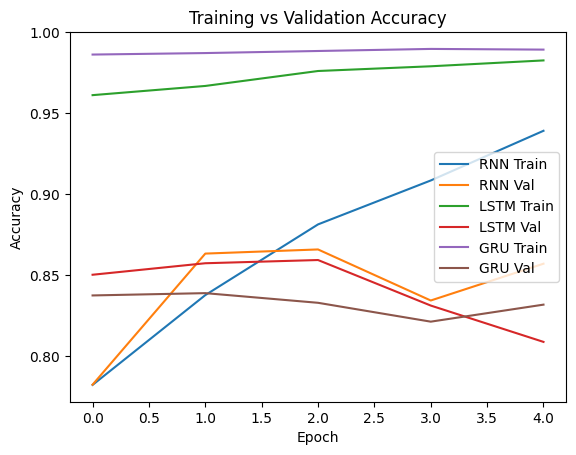

In [ ]:
plt.plot(history_rnn.history['accuracy'], label='RNN Train')
plt.plot(history_rnn.history['val_accuracy'], label='RNN Val')
plt.plot(history_LSTM.history['accuracy'], label='LSTM Train')
plt.plot(history_LSTM.history['val_accuracy'], label='LSTM Val')
plt.plot(history_GRU.history['accuracy'], label='GRU Train')
plt.plot(history_GRU.history['val_accuracy'], label='GRU Val')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

###Nhận xét chung:

Biểu đồ cho thấy sự thay đổi về độ chính xác trên tập huấn luyện (Training Accuracy) và tập kiểm định (Validation Accuracy) qua 5 epoch cho mỗi mô hình. Mục tiêu là có Training Accuracy cao và gần với Validation Accuracy, tránh khoảng cách lớn giữa hai đường này (dấu hiệu của overfitting).

###Phân tích chi tiết từng mô hình:

1. Mô hình RNN (Đường màu xanh dương - Train, màu cam - Val):
- Training Accuracy: Bắt đầu ở mức khá (khoảng 0.78) và tăng đều đặn qua các epoch, đạt mức rất cao (gần 1.0) ở cuối quá trình huấn luyện. Điều này cho thấy mô hình học rất tốt trên dữ liệu huấn luyện.
- Validation Accuracy: Bắt đầu ở mức tương đương với Training Accuracy (khoảng 0.78), tăng lên đáng kể ở epoch thứ 2 (khoảng 0.86), sau đó có xu hướng giảm nhẹ hoặc dao động.
- So sánh Train và Val: Ban đầu hai đường gần nhau. Từ epoch thứ 2 trở đi, Training Accuracy tăng vọt trong khi Validation Accuracy có xu hướng đi ngang hoặc giảm nhẹ. Khoảng cách giữa hai đường này ngày càng lớn ở các epoch sau.
- Kết luận: Mô hình RNN cho thấy dấu hiệu overfitting (quá khớp) rõ rệt từ epoch thứ 2 hoặc 3 trở đi. Mô hình học quá kỹ dữ liệu huấn luyện, dẫn đến hiệu suất trên dữ liệu mới (tập kiểm định) không cải thiện tương ứng, thậm chí còn giảm nhẹ. Mặc dù có overfitting, Validation Accuracy của RNN vẫn giữ ở mức khá tốt (khoảng 0.85 ở đỉnh).
2. Mô hình LSTM (Đường màu xanh lá cây - Train, màu đỏ - Val):
- Training Accuracy: Bắt đầu ở mức rất cao (khoảng 0.96) và tiếp tục tăng rất nhanh, đạt gần 100% ở các epoch cuối. Mô hình học dữ liệu huấn luyện cực kỳ hiệu quả.
- Validation Accuracy: Bắt đầu ở mức thấp hơn Training Accuracy một chút (khoảng 0.85), tăng nhẹ ở các epoch đầu, sau đó lại giảm dần và kết thúc ở mức rất thấp (khoảng 0.81).
- So sánh Train và Val: Ngay từ epoch đầu tiên, Training Accuracy đã cao hơn đáng kể so với Validation Accuracy. Khoảng cách này ngày càng rộng ra một cách nhanh chóng.
- Kết luận: Mô hình LSTM cũng cho thấy dấu hiệu overfitting rất nghiêm trọng và nhanh chóng. Mặc dù đạt Training Accuracy gần như hoàn hảo, hiệu suất trên tập kiểm định lại rất kém và có xu hướng giảm. Điều này giải thích tại sao độ chính xác trên tập kiểm tra (test set) của LSTM lại thấp nhất trong ba mô hình.
3. Mô hình GRU (Đường màu tím - Train, màu nâu - Val):
- Training Accuracy: Tương tự như LSTM, Training Accuracy của GRU bắt đầu ở mức rất cao (khoảng 0.98) và tăng nhanh, đạt gần 100% ở cuối quá trình huấn luyện. Mô hình học dữ liệu huấn luyện cực kỳ tốt.
- Validation Accuracy: Bắt đầu ở mức thấp hơn Training Accuracy (khoảng 0.84), dao động quanh mức này và có xu hướng giảm nhẹ ở các epoch cuối.
- So sánh Train và Val: Tương tự như LSTM, khoảng cách giữa Training Accuracy và Validation Accuracy là rất lớn ngay từ đầu và tiếp tục tăng lên.
- Kết luận: Mô hình GRU cũng bị overfitting nghiêm trọng, mặc dù có vẻ ít nghiêm trọng hơn LSTM một chút ở các epoch đầu. Hiệu suất trên tập kiểm định không được duy trì và có xu hướng giảm khi mô hình học quá sâu vào dữ liệu huấn luyện.

###So sánh tổng thể:
- Cả ba mô hình đều cho thấy dấu hiệu overfitting, với Training Accuracy rất cao nhưng Validation Accuracy không theo kịp.
- Mô hình RNN có vẻ là mô hình ít bị overfitting nhất trong ba mô hình, thể hiện qua Validation Accuracy duy trì ở mức tương đối ổn định và cao hơn so với - LSTM và GRU, đặc biệt là ở các epoch đầu. Điều này phù hợp với kết quả đánh giá trên tập kiểm tra (test accuracy) cho thấy RNN có hiệu suất tốt nhất.
- Mô hình LSTM và GRU học dữ liệu huấn luyện rất nhanh và đạt độ chính xác gần như hoàn hảo, nhưng lại không thể khái quát hóa tốt trên dữ liệu mới, dẫn đến overfitting nặng và Validation Accuracy thấp.